# Enefit - Predict Energy Behavior of Prosumers
<h4>Predict Prosumer Energy Patterns and Minimize Imbalance Costs:</h4>
<p>Your challenge in this competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels. You'll have access to weather data, the relevant energy prices, and records of the installed photovoltaic capacity.</p>

<b>Estonia: 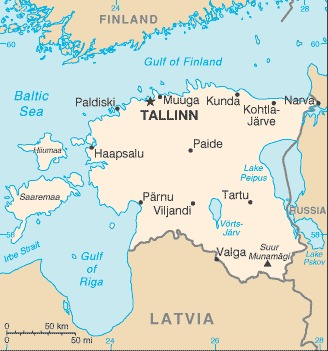 centroid = (26.0, 59.0) 

In [1]:
centroid = (26.0, 59.0)

In [2]:
import json
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sklearn

In [3]:
import geopandas as gpd

/Users/blcrosbie/dev/public/kaggle/predict-energy-behavior-of-prosumers/venv/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from mapclassify import MaxP

In [202]:
import datetime
import pytz
import holidays
import optuna
import joblib

In [6]:
from typing import Optional,Dict,Tuple
from pathlib import Path

In [7]:
from xgboost import XGBRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [409]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('.'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from solar_tracking import calculate_elevation_angle, calculate_irradiation_on_surface

In [21]:
os.chdir('../')

plt.style.use("ggplot")
plt.rcParams.update(**{'figure.dpi': 150})

### Load Files

In [22]:
ESTONIA_GPKG = "estonia.gpkg"

# Coordinate Reference System (CRS)
ESTONIA_CRS = "EPSG:4133"

In [405]:
# Read in all spatial layers
# boundry = gpd.read_file(ESTONIA_GPKG, layer='boundry', driver="GPKG", crs=ESTONIA_CRS)
counties = gpd.read_file(os.path.join(os.getcwd(), ESTONIA_GPKG), layer='counties', driver="GPKG", crs=ESTONIA_CRS)
# municipalities = gpd.read_file(ESTONIA_GPKG, layer='municipalities', driver="GPKG", crs=ESTONIA_CRS)
# settlements = gpd.read_file(ESTONIA_GPKG, layer='settlements', driver="GPKG", crs=ESTONIA_CRS)
station = pd.read_csv('weather_station_to_county_mapping.csv')
dtypes={'latitude': 'float', 'longitude': 'float', 'county': 'int'}
station = station.dropna()
for col, dtype in dtypes.items():
    station[col] = station[col].astype(dtype)
    if dtype == 'float':
        station[col] = station[col].apply(lambda x: round(x, 1))
        
station_gdf = gpd.GeoDataFrame(
    station, geometry=gpd.points_from_xy(station.longitude, station.latitude), crs=ESTONIA_CRS
)

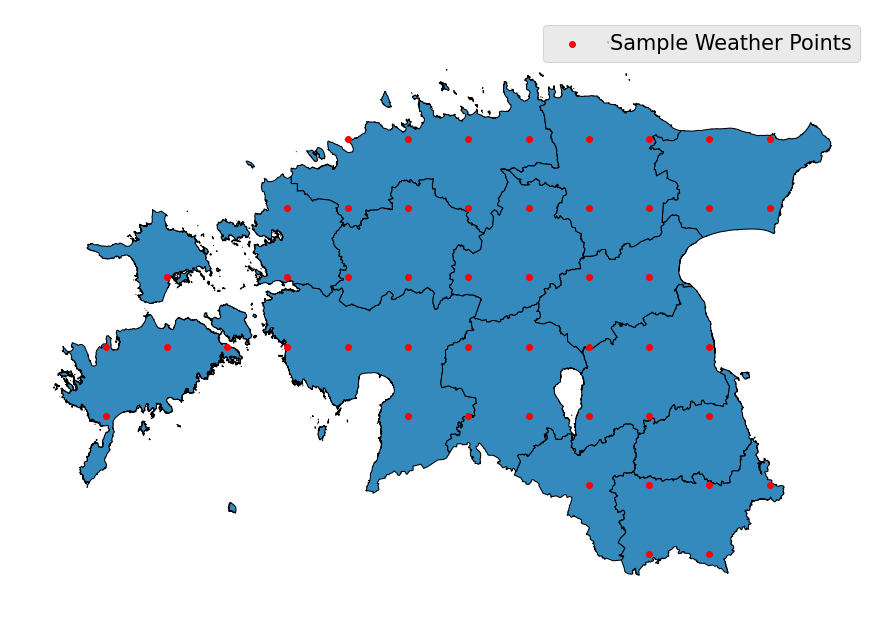

In [414]:
# Plot the counties of Estonia as well as the centroids of the Weather Data Sample Points
fig, ax = plt.subplots(figsize=(6,8))
counties.plot(edgecolor='k',ax=ax)
station_gdf.centroid.plot(markersize=8,color='red',ax=ax, label="Sample Weather Points")
plt.legend()
plt.axis('off')
plt.tight_layout();

### Helper Functions for Handling Datetime

In [306]:
def bin_data(values, k, interval="equal"):
    """
    Given a list of values, 'k' bin
    return categorical bin group ids in specified intervals
    """
    min_val = values.min()
    max_val = values.max()
    
    binned_data = []
    thresholds = []
    
    if interval == "equal":
        intv = (max_val - min_val) / k
        thresholds = [i*intv for i in range(k)]
        
    elif interval == "stdev":
        intv = values.std()
        avg = values.mean()
        if k % 2 == 0:
            k_half = int(k/2)
            k_res = 0
        else:
            k_half = int((k-1)/2)
            k_res = 0.5
            
        for i in range(-1*k_half, k_half+1):
            if i == 0 and k_res == 0:
                pass
            else:
                thresholds.append((i*intv) + avg)

    elif interval == "equal_count":
        pass
        
    elif interval == "quantile":
        pass
    
    elif interval == "log_scale":
        pass

    else:
        pass
    

    binned_data = []
    for val in values:
        for j in range(0, len(thresholds)):
            if val < thresholds[j]:
                binned_data.append(j)
            else:
                pass
    
    return pd.Series(binned_data)
    
    


def extract_dt_attributes(df: pd.DataFrame):
    earliest_time = df.datetime.min()
    # convert datetime column, if not done already
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # dates and times
    df['date'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.strftime('%H:%M:%S')
    
    #
    df['year'] = df['datetime'].dt.year
    df['day_of_year'] = df['datetime'].dt.strftime('%j').astype(int)
    df['datediff_in_days'] = (
        df['datetime']- earliest_time
    ).dt.days
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    
    for col in time_features:
        if col=='week':
            df[col] = df['datetime'].dt.isocalendar().week.astype(np.int32)
        else:
            df[col] = getattr(df['datetime'].dt,col)
        
        
        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[col]
        angles = 2*np.pi*(df[col]-col_min)/(col_max-col_min+1)
        
        # add sin and cos
        df[col+'_sine'] = np.sin(angles).astype('float')
        df[col+'_cosine'] = np.cos(angles).astype('float')
    return df


def handle_timezone(dt: datetime):
    """
    https://www.timeanddate.com/time/change/estonia/tallinn
    """
    year = dt.year
    
    if year == 2021:
        
        if dt >= datetime.datetime.strptime("2021-10-31 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        else:
            utc_offset = 3
        
        
    elif year == 2022:
        
        if dt < datetime.datetime.strptime("2022-03-27 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        elif dt >= datetime.datetime.strptime("2022-10-30 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        else:
            utc_offset = 3
        
        
        
    elif year == 2023:
        
        if dt < datetime.datetime.strptime("2023-03-26 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
            
        elif dt >= datetime.datetime.strptime("2023-10-29 03:00:00", '%Y-%m-%d %H:%M:%S'):
            utc_offset = 2
        
        else:
            utc_offset = 3
        
        
    else:
        pass
    
    return utc_offset

def datetime_inference_attributes(dt: datetime):
    
    # dates and times
    date = dt.date
    time = dt.strftime('%H:%M:%S')

    year = dt.year
    day_of_year = dt.timetuple().tm_yday
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    time_data = {}
    
    for key in time_features:
        if col=='week':
            time_data[key] = dt.isocalendar().week.astype(np.int32)
        else:
            time_data[key] = getattr(dt, key)
        
        
        ## sin and cosine features to capture the circular continuity
        key_min, key_max = time_features[key]
        angles = 2*np.pi*(time_data[key]-key_min)/(key_max-key_min+1)
        
        # add sin and cos
        time_data[f'{key}_sin'] = np.sin(angles).astype('float')
        time_data[f'{key}_cos'] = np.cos(angles).astype('float')
        
    time_data['date'] = date
    time_data['time'] = time
    time_data['year'] = year
    time_data['day_of_year'] = day_of_year
    return time_data

### Load the datasets

In [371]:
weather = pd.read_csv('historical_weather.csv', parse_dates=['datetime'], dtype={'data_block_id': 'int'})
forecast = pd.read_csv('forecast_weather.csv', parse_dates=['origin_datetime', 'forecast_datetime'], dtype={'data_block_id': 'int'})

In [221]:
weather['utc_offset'] = weather.datetime.apply(handle_timezone)

In [223]:
forecast['utc_offset'] = forecast.origin_datetime.apply(handle_timezone)

In [226]:
weather_gdf = gpd.GeoDataFrame(
    weather, geometry=gpd.points_from_xy(weather.longitude, weather.latitude), crs=ESTONIA_CRS
)

In [227]:
forecast_gdf = gpd.GeoDataFrame(
    forecast, geometry=gpd.points_from_xy(forecast.longitude, forecast.latitude), crs=ESTONIA_CRS
)

In [228]:
county_data = gpd.overlay(counties,\
                          weather_gdf,\
                          how='intersection',\
                          keep_geom_type=False\
)

In [229]:
county_pred = gpd.overlay(counties,\
                          forecast_gdf,\
                          how='intersection',\
                          keep_geom_type=False\
)

In [395]:
weather_lookup = {}
data_block_id_list = county_data.data_block_id.drop_duplicates().to_list()
county_code_list = list(range(16))
for dbid in data_block_id_list:
    this_weather_block = county_data[county_data.data_block_id == dbid]
    weather_lookup[dbid] = {}
    for cty in county_code_list:
        this_cty_weather = this_weather_block[this_weather_block.countyCodes == str(cty)].reset_index(drop=True)
        cty_lookup = []
        for rw in this_cty_weather.index:
            this_cty_row = this_cty_weather.iloc[rw].to_dict()
            cty_lookup.append(this_cty_row)
            
        weather_lookup[dbid][cty] = cty_lookup

In [399]:
forecast_lookup = {}
data_block_id_list = county_pred.data_block_id.drop_duplicates().to_list()
county_code_list = list(range(16))
for dbid in data_block_id_list:
    this_forecast_block = county_pred[county_pred.data_block_id == dbid]
    forecast_lookup[dbid] = {}
    for cty in county_code_list:
        this_cty_forecast = this_forecast_block[this_forecast_block.countyCodes == str(cty)].reset_index(drop=True)
        cty_lookup = []
        for rw in this_cty_forecast.index:
            this_cty_row = this_cty_forecast.iloc[rw].to_dict()
            cty_lookup.append(this_cty_row)
            
        forecast_lookup[dbid][cty] = cty_lookup

In [433]:
weather_lookup[1][0]

[{'countyCodes': '0',
  'county_name': 'HARJUMAA',
  'county_id': '0037',
  'area': 4312853674.405274,
  'datetime': Timestamp('2021-09-01 00:00:00'),
  'temperature': 13.5,
  'dewpoint': 10.5,
  'rain': 0.0,
  'snowfall': 0.0,
  'surface_pressure': 1009.5,
  'cloudcover_total': 46,
  'cloudcover_low': 49,
  'cloudcover_mid': 0,
  'cloudcover_high': 7,
  'windspeed_10m': 4.416666666666667,
  'winddirection_10m': 347,
  'shortwave_radiation': 0.0,
  'direct_solar_radiation': 0.0,
  'diffuse_radiation': 0.0,
  'latitude': 59.1,
  'longitude': 24.2,
  'data_block_id': 1,
  'utc_offset': 3,
  'geometry': <POINT (24.2 59.1)>},
 {'countyCodes': '0',
  'county_name': 'HARJUMAA',
  'county_id': '0037',
  'area': 4312853674.405274,
  'datetime': Timestamp('2021-09-01 00:00:00'),
  'temperature': 12.6,
  'dewpoint': 10.5,
  'rain': 0.0,
  'snowfall': 0.0,
  'surface_pressure': 1004.8,
  'cloudcover_total': 90,
  'cloudcover_low': 98,
  'cloudcover_mid': 3,
  'cloudcover_high': 0,
  'windspeed_10

In [237]:
train_df = pd.read_csv('train.csv', parse_dates=['datetime'])

In [239]:
client_df = pd.read_csv('client.csv', parse_dates=['date'])

In [241]:
with open('county_id_to_name_map.json', 'r') as fw:
    county_lookup = json.load(fw)

In [361]:
station_by_county = station
station_lookup = {}
for cty in station.county.drop_duplicates().to_list():
    this_cty = station[station.county == cty].reset_index(drop=True)
    this_cty_rows = []
    for rw in this_cty.index:
        this_cty_row = this_cty.iloc[rw].to_dict()
        this_cty_rows.append(this_cty_row)
        
    station_lookup[cty] = this_cty_rows

In [245]:
electricity_df = pd.read_csv('electricity_prices.csv', parse_dates=['forecast_date', 'origin_date'])
gas_df = pd.read_csv('gas_prices.csv', parse_dates=['forecast_date', 'origin_date'])

### Emulate the Order of Operations based on the Input Fields given from API

In [282]:
known_columns = [
    'county', 'is_business', 'product_type', 'is_consumption', 
    'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'target'
]

unknown_columns = ['row_id', 'target']

input_df = train_df[known_columns]
output_df = train_df[unknown_columns]
# input_df = input_df.set_index('row_id')
# output_df = output_df.set_index('row_id')

In [284]:
data_blocks = input_df.data_block_id.drop_duplicates().to_list()

In [292]:
train = {}
for dbid in data_blocks:
    api_data_block = input_df[input_df.data_block_id == dbid]
    api_data_block = api_data_block.reset_index(drop=True)
    data_block_list = []
    for rw in api_data_block.index:
        this_row_data = api_data_block.iloc[rw].to_dict()
        data_block_list.append(this_row_data)
        
    train[dbid] = data_block_list

    

In [427]:
train[0]

[{'index': 0,
  'county': 0,
  'is_business': 0,
  'product_type': 1,
  'is_consumption': 0,
  'datetime': Timestamp('2021-09-01 00:00:00'),
  'data_block_id': 0,
  'row_id': 0,
  'prediction_unit_id': 0,
  'target': 0.713,
  'utc_offset': 3,
  'hour': 0,
  'hour_sin': 0.0,
  'hour_cos': 1.0,
  'dayofweek': 2,
  'dayofweek_sin': 0.9749279121818236,
  'dayofweek_cos': -0.22252093395631434,
  'week': 35,
  'week_sin': -0.8229838658936564,
  'week_cos': -0.5680647467311559,
  'month': 9,
  'month_sin': -0.8660254037844384,
  'month_cos': -0.5000000000000004,
  'date': <function Timestamp.date>,
  'time': '00:00:00',
  'year': 2021,
  'day_of_year': 244,
  'station_0_county_name': 'Harjumaa',
  'station_0_longitude': 24.2,
  'station_0_latitude': 59.09999999999999,
  'station_0_county': 0,
  'station_1_county_name': 'Harjumaa',
  'station_1_longitude': 24.2,
  'station_1_latitude': 59.399999999999984,
  'station_1_county': 0,
  'station_2_county_name': 'Harjumaa',
  'station_2_longitude': 

#### 1. Handle Datetime
#### 2. Location -> Weather Reports + Forecast Information

In [430]:
test_count = 1
for dbid, api_data in train.items():
    dbid = 1
    for row in api_data:
        
        # Datetime Operations:
        dt = row['datetime']
        
        # Get UTC offset 
        utc_offset = handle_timezone(dt)
        row.update({'utc_offset': utc_offset})
        
        # Get cyclic information and other datetime inferences
        dt_inference = datetime_inference_attributes(dt)
        row.update(dt_inference)
        
        # Get Location
        county = row['county']
        #stations = station_lookup[county]
        #station_ndx = 0
        #for station in stations:
        #    for k, v in station.items():
        #        station_key = f'station_{k}_{station_ndx}'
        #        row[station_key] = v
        #    station_ndx += 1
            
        # Get Weather History
        print(dbid)
        print(county)
        if dbid in weather_lookup:
            if county in weather_lookup[dbid]:
                this_weather = weather_lookup[dbid][county]
                
                station_ndx = 0
                for w in this_weather:
                    for k, v in w.items():
                        station_key = f'{k}_station_{station_ndx}'
                        row[station_key] = v
                    station_ndx += 1
            else:
                pass
        else:
            pass
            
        # Get Weather Forecast
        if dbid in forecast_lookup:
            if county in forecast_lookup[dbid]:
                this_forecast = forecast_lookup[dbid][county]
                station_ndx = 0
                for f in this_forecast:
                    for k, v in f.items():
                        station_key = f'{k}_station_{station_ndx}'
                        row[station_key] = v
                    station_ndx += 1
            else:
                this_forecast = {}
        else:
            this_forecast = {}
        
            
            
            
        for k, v in row.items():
            print(k, v)
        print(STOP)
        
        

    
    test_count -= 1
    if test_count == 0:
        print(STOP)

1
0
index 0
county 0
is_business 0
product_type 1
is_consumption 0
datetime 2021-09-01 00:00:00
data_block_id 0
row_id 0
prediction_unit_id 0
target 0.713
utc_offset 3
hour 0
hour_sin 0.0
hour_cos 1.0
dayofweek 2
dayofweek_sin 0.9749279121818236
dayofweek_cos -0.22252093395631434
week 35
week_sin -0.8229838658936564
week_cos -0.5680647467311559
month 9
month_sin -0.8660254037844384
month_cos -0.5000000000000004
date <built-in method date of Timestamp object at 0x7faa88d195d0>
time 00:00:00
year 2021
day_of_year 244
station_0_county_name Harjumaa
station_0_longitude 24.2
station_0_latitude 59.09999999999999
station_0_county 0
station_1_county_name Harjumaa
station_1_longitude 24.2
station_1_latitude 59.399999999999984
station_1_county 0
station_2_county_name Harjumaa
station_2_longitude 24.7
station_2_latitude 59.399999999999984
station_2_county 0
station_3_county_name Harjumaa
station_3_longitude 25.2
station_3_latitude 59.09999999999999
station_3_county 0
station_4_county_name Harjuma

NameError: name 'STOP' is not defined

In [423]:
weather_lookup[1][0]

[{'countyCodes': '0',
  'county_name': 'HARJUMAA',
  'county_id': '0037',
  'area': 4312853674.405274,
  'datetime': Timestamp('2021-09-01 00:00:00'),
  'temperature': 13.5,
  'dewpoint': 10.5,
  'rain': 0.0,
  'snowfall': 0.0,
  'surface_pressure': 1009.5,
  'cloudcover_total': 46,
  'cloudcover_low': 49,
  'cloudcover_mid': 0,
  'cloudcover_high': 7,
  'windspeed_10m': 4.416666666666667,
  'winddirection_10m': 347,
  'shortwave_radiation': 0.0,
  'direct_solar_radiation': 0.0,
  'diffuse_radiation': 0.0,
  'latitude': 59.1,
  'longitude': 24.2,
  'data_block_id': 1,
  'utc_offset': 3,
  'geometry': <POINT (24.2 59.1)>},
 {'countyCodes': '0',
  'county_name': 'HARJUMAA',
  'county_id': '0037',
  'area': 4312853674.405274,
  'datetime': Timestamp('2021-09-01 00:00:00'),
  'temperature': 12.6,
  'dewpoint': 10.5,
  'rain': 0.0,
  'snowfall': 0.0,
  'surface_pressure': 1004.8,
  'cloudcover_total': 90,
  'cloudcover_low': 98,
  'cloudcover_mid': 3,
  'cloudcover_high': 0,
  'windspeed_10

In [ ]:
train_df = extract_dt_attributes(train_df)

### Visualize Solar Irradiance by County per Month

In [61]:
# county_data['direct_solar_bin'] = bin_data(county_data['direct_solar_radiation'], k=6, interval="stdev")

In [46]:
# for month in range(1, 13):

#     monthly_avg = county_data[(county_data.month == month) & (county_data.direct_solar_radiation > 0.0)].groupby(by=['countyCodes']).median()
#     monthly_max = county_data[(county_data.month == month) & (county_data.direct_solar_radiation > 0.0)].groupby(by=['countyCodes']).max()
#     monthly_avg = pd.merge(monthly_avg.reset_index(), counties, on='countyCodes')
#     monthly_max = pd.merge(monthly_max.reset_index(), counties, on='countyCodes')

#     fig, ax = plt.subplots(2, 1, sharex=True, sharey=True)

#     divider_0 = make_axes_locatable(ax[0])
#     divider_1 = make_axes_locatable(ax[1])

#     cax_0 = divider_0.append_axes("top", size="5%", pad=0.5)
#     cax_1 = divider_1.append_axes("bottom", size="5%", pad=0.5)

#     monthly_avg.plot(
#         column="direct_solar_radiation",
#         ax=ax[0],
#         legend=True,
#         cax=cax_0,
#         legend_kwds={"label": f"Nom Direct Solar Radiation: Month {month}", "orientation": "horizontal"},
#         cmap='OrRd'
#     );
#     monthly_max.plot(
#         column="direct_solar_radiation",
#         ax=ax[1],
#         legend=True,
#         cax=cax_1,
#         legend_kwds={"label": f"Max Direct Solar Radiation: Month {month}", "orientation": "horizontal"}
#     );
    
    
#     print("\n\n\n")

### Solar Production Analysis

In [65]:
spa = train_df[train_df['is_consumption'] == 0]
spa = spa.rename(columns={'county': 'countyCodes'})
spa['countyCodes'] = spa['countyCodes'].astype(str)
spa = spa.set_index('countyCodes', 'datetime')
county_data['countyCodes'] = county_data['countyCodes'].astype(str)
county_weather_data = county_data.set_index('countyCodes', 'datetime')
spa = pd.merge(spa, county_weather_data, on=['countyCodes', 'datetime'])

/Users/blcrosbie/dev/public/kaggle/predict-energy-behavior-of-prosumers/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  after removing the cwd from sys.path.
/Users/blcrosbie/dev/public/kaggle/predict-energy-behavior-of-prosumers/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only
  


In [75]:
filter_columns_spa = ['countyCodes', 'datetime', 'is_business', 'product_type', 'prediction_unit_id', 'target', 
                      'direct_solar_radiation', 'diffuse_radiation', 'shortwave_radiation',
                      'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total',
                      'cloudcover_low', 'cloudcover_mid', 'cloudcover_high',
                      'dayofweek', 'dayofweek_sine', 'dayofweek_cosine', 'week', 'week_sine', 'week_cosine',
                      'month', 'month_sine', 'month_cosine', 'day_of_year', 'latitude', 'longitude']

x_columns = [col for col in filter_columns_spa if col != "target"]
y_columns = ["target"]
spa = spa.reset_index()
spa = spa[filter_columns_spa]
spa

,countyCodes,datetime,is_business,product_type,prediction_unit_id,target,direct_solar_radiation,diffuse_radiation,shortwave_radiation,temperature,...,dayofweek_cosine,week,week_sine,week_cosine,month,month_sine,month_cosine,day_of_year,latitude,longitude
0,0,2021-09-01 00:00:00,0,1,0,0.713,0.0,0.0,0.0,13.5,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,244,59.1,24.2
1,0,2021-09-01 00:00:00,0,1,0,0.713,0.0,0.0,0.0,12.6,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,244,59.1,25.2
2,0,2021-09-01 00:00:00,0,1,0,0.713,0.0,0.0,0.0,14.6,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,244,59.4,24.2
3,0,2021-09-01 00:00:00,0,1,0,0.713,0.0,0.0,0.0,14.2,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,244,59.4,24.7
4,0,2021-09-01 00:00:00,0,1,0,0.713,0.0,0.0,0.0,13.8,...,-0.222521,35,-0.822984,-0.568065,9,-0.866025,-0.5,244,59.4,25.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3593933,15,2023-05-30 10:00:00,1,3,60,496.085,390.0,180.0,570.0,14.2,...,0.623490,22,0.568065,-0.822984,5,0.866025,-0.5,150,57.6,26.7
3593934,15,2023-05-30 10:00:00,1,3,60,496.085,312.0,206.0,518.0,13.8,...,0.623490,22,0.568065,-0.822984,5,0.866025,-0.5,150,57.6,27.2
3593935,15,2023-05-30 10:00:00,1,3,60,496.085,249.0,241.0,490.0,13.9,...,0.623490,22,0.568065,-0.822984,5,0.866025,-0.5,150,57.9,26.7
3593936,15,2023-05-30 10:00:00,1,3,60,496.085,257.0,241.0,498.0,13.9,...,0.623490,22,0.568065,-0.822984,5,0.866025,-0.5,150,57.9,27.2


In [68]:
spa['elevation'] = spa[['datetime', 'day_of_year', 'longitude', 'latitude']].apply(
    lambda x: calculate_elevation_angle(
        local_time=x[0], day_of_year=x[1], longitude=x[2], latitude=x[3], utc_offset=2
    ), axis=1
)

In [134]:
spa.product_type.value_counts()

3    1466400
1    1381204
0     383841
2     362493
Name: product_type, dtype: int64

In [136]:
X = spa[x_columns]
del X['datetime']
y = spa[y_columns]

In [137]:
X_business = X[X.is_business == 1]
X_consumer = X[X.is_business == 0]

In [138]:
X_business.product_type.value_counts()

3    748475
1    666159
0    383841
2    164475
Name: product_type, dtype: int64

In [139]:
X_consumer.product_type.value_counts()

3    717925
1    715045
2    198018
Name: product_type, dtype: int64

In [111]:
category_columns = ['countyCodes', 'is_business', 'product_type', 'prediction_unit_id']


for col in category_columns:
    X[col] = X[col].astype('category')
    del X[col]
X.dtypes

/Users/blcrosbie/dev/public/kaggle/predict-energy-behavior-of-prosumers/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


direct_solar_radiation    float64
diffuse_radiation         float64
shortwave_radiation       float64
temperature               float64
dewpoint                  float64
rain                      float64
snowfall                  float64
surface_pressure          float64
cloudcover_total            int64
cloudcover_low              int64
cloudcover_mid              int64
cloudcover_high             int64
dayofweek                   int64
dayofweek_sine            float64
dayofweek_cosine          float64
week                        int32
week_sine                 float64
week_cosine               float64
month                       int64
month_sine                float64
month_cosine              float64
day_of_year                 int64
latitude                  float64
longitude                 float64
dtype: object

In [112]:
y = y.fillna(0)

In [124]:
def fit_model(
    X:pd.DataFrame,
    y:pd.Series,
    config:Optional[Dict]=None,
    n_jobs:int=1,
) -> XGBRegressor:
    '''
    Train a xgboost regressor with L1 loss
    '''
    model = XGBRegressor(
        objective='reg:absoluteerror',
        tree_method='hist',
        n_jobs=n_jobs,
        enable_categorical=True,
        base_score=y.mean()
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    
    return model.fit(X,y)

In [114]:
model_1 = XGBRegressor()
# model_1.enable_categorical = True
model_1.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [123]:
test_ndx = 3593933
y_hat = []
for ndx in X.index:
    test_row = np.asarray([X.iloc[ndx]])
    pred_val = model_1.predict(test_row)
    y_hat.append(pred_val)
    
# actual_val = y.iloc[test_ndx]

# make a prediction
# yhat = model_1.predict(test_row)

# summarize prediction
# print('Predicted: %.3f' % yhat)
# print('Actual: %.3f' % actual_val)

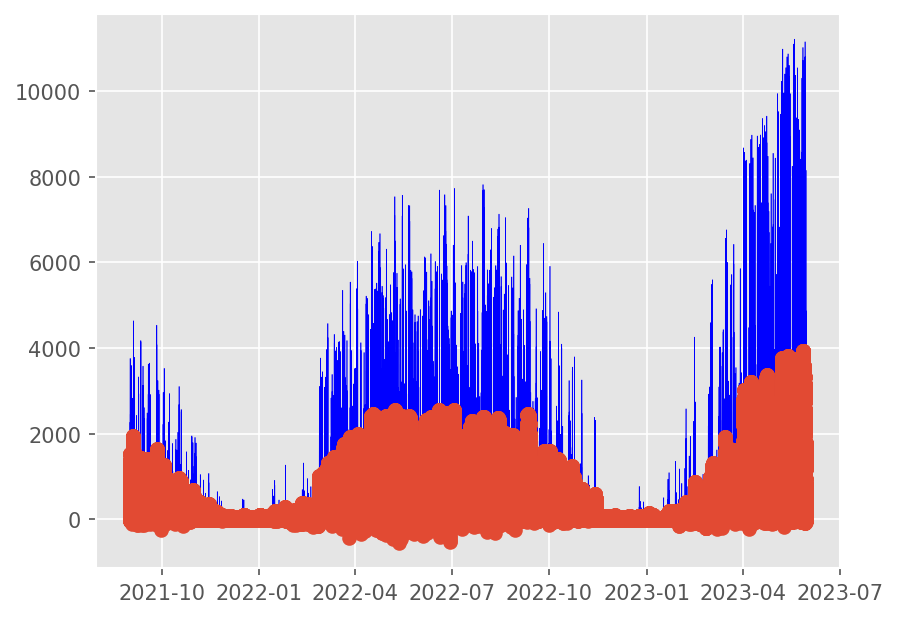

In [132]:
times = spa.datetime.to_list()
plt.plot(times, y.target.to_list(), 'b', linewidth=0.3)
plt.plot(times, y_hat, 'o', linewidth=0.3)

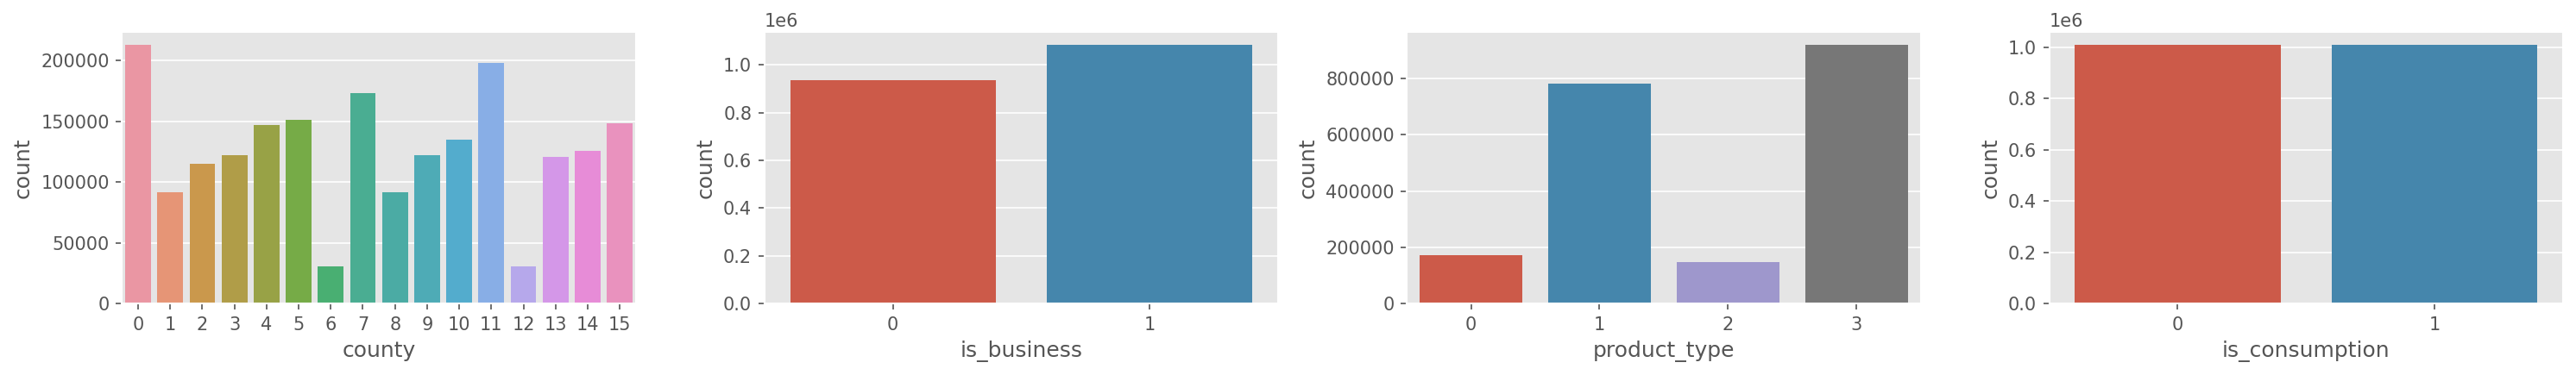

In [63]:
# counts for the country,store,product
desc_columns = ['county','is_business','product_type','is_consumption']

fig, axs = plt.subplots(1, len(desc_columns), figsize=(5*len(desc_columns), 3))

for i, column in enumerate(desc_columns):
    _ = sns.countplot(train_df, x=column, ax=axs[i])

_ = fig.tight_layout()

In [ ]:
train_avgd = (
    train_df
    .groupby(['datetime','is_consumption'])
    ['target'].mean()
    .unstack()
    .rename({0: 'produced', 1:'consumed'}, axis=1)
)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
_ = train_avgd.plot(ax=ax, alpha=0.5)
_ = ax.set_ylabel('Energy consumed / produced')

In [ ]:
# plot of average weekly sales
fig,ax = plt.subplots(1,1,figsize=(6,4))
_ = train_avgd.resample('M').mean().plot(ax=ax, marker='.')
_ = ax.set_ylabel('Average monthly')

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,4))
train_avgd.groupby(train_avgd.index.hour).mean().plot(ax=ax, marker='.')
_ = ax.set_xlabel('Hour')

In [ ]:
# get train attributes
extract_dt_attributes(train_df)

In [ ]:
categorical_cols = ['county', 'product_type']
for column in categorical_cols:
    train_df[column] = train_df[column].astype('category')

In [ ]:
train_df[train_df['is_consumption'] == 0][['target', 'hour', 'month']].groupby(by=['month', 'hour']).mean()

In [ ]:
client_df[(client_df.data_block_id == 4) & (client_df.county == 0)]

In [ ]:
train_df[(train_df.data_block_id == 1) & (train_df.county == 0)]

In [ ]:
print(f"Total Observed Hours: {len(train_df.datetime.drop_duplicates().to_list())}")
print(f"Counties: {len(train_df.county.drop_duplicates().to_list())}")
print(f"Prediction Types: {len(train_df.prediction_unit_id.drop_duplicates().to_list())}")
print(f"Data Blocks: {len(train_df.data_block_id.drop_duplicates().to_list())}")

<h4>Business</h4|>

In [ ]:
for county_id in train_df.county.drop_duplicates().to_list()[0:1]:
    county_df = train_df[train_df.county == county_id]
    for product_type in county_df.product_type.drop_duplicates().to_list()[0:1]:
        cpt_df = county_df[county_df.product_type == product_type]
        consumed_df = cpt_df[(cpt_df.is_business == 1) & (cpt_df.is_consumption == 1)]
        print(consumed_df.sort_values('datetime', ascending=True))
        x = range(len(consumed_df))
        y = consumed_df.target.to_list()
        plt.plot(x, y)
        plt.show()



<h4>Consumer</h4>

In [ ]:
for county_id in train_df.county.drop_duplicates().to_list()[0:1]:
    county_df = train_df[train_df.county == county_id]
    for product_type in county_df.product_type.drop_duplicates().to_list():
        cpt_df = county_df[county_df.product_type == product_type]
        non_biz_cpt_df = cpt_df[cpt_df.is_business == 0]
        print(non_biz_cpt_df)